# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [6]:
import os
from pathlib import Path
import random
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import imgaug.augmenters as iaa
import keras
from keras.utils import Sequence
from keras.utils.np_utils import to_categorical   
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import pandas

from weighted_loss_unet import make_weighted_loss_unet, my_loss
import monuseg_utils

In [15]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 5

## Investigating data

In [132]:
data_dir = Path(os.getcwd()).parent / 'data/swebcg91rt'
with open(data_dir / 'annotations.json') as f:
    annotations = json.load(f)

monuseg_utils.parse_annotations(annotations)

img_list = []
for img_id, data in annotations.items():
    img_dict = {"image_id" : img_id}
    for item in data:
        celltype = item['class']
        if not celltype in img_dict:
            img_dict[celltype] = 1
        else:
            img_dict[celltype] += 1 
    img_list.append(img_dict)
    
df = pandas.DataFrame(img_list)
df.set_index("image_id")
print(df.sum()[1:])

immune cells    593
tumor           658
necrosis          6
stroma          421
rbc              30
dtype: object


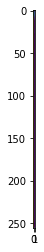

In [15]:
# TODO: make this work
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection) / (union)
    return (1-jac)

model = keras.models.load_model('./models/unet_model.h5',
                        custom_objects={'my_loss' : my_loss, 'iou': iou})
model_inference = make_weighted_loss_unet((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), 2, False)
model_inference.set_weights(model.get_weights())

test_seq = iaa.Sequential([
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT)
])

ims = [imread(data_dir / i) for i in random.choices(os.listdir(data_dir), k=5)]
aug_ims = np.asarray(test_seq(images=ims))
preds = model_inference.predict(aug_ims)

plt.figure()
plt.imshow(preds[3,:,:,1])
plt.figure()
plt.imshow(aug_ims[3])

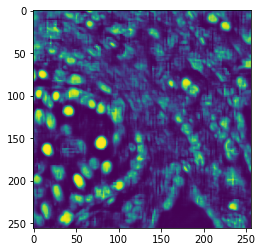

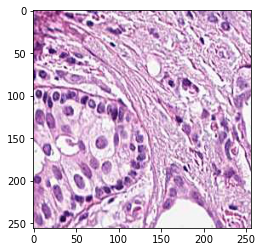